<a href="https://colab.research.google.com/github/voleka-ocrv/AvitoAnalyticsAcademy/blob/main/ch5_Monte_Karlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#5.1. [Метод Монте-Карло](https://www.youtube.com/watch?v=NoBJbrweIoc)

In [ ]:
import numpy
from matplotlib import pyplot
from seaborn import displot
from scipy.stats import norm
from scipy.stats import expon
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import CompareMeans, DescrStatsW

In [ ]:
numpy.random.seed(42)

bad_cnt = 0
N= 10000
alpha = 0.05

sample_dist = norm(loc=2, scale=3)
mu0 = sample_dist.expect()

for i in range(N):

  # Генерирую выборку теста и контроля
  test    = sample_dist.rvs(10)
  control = sample_dist.rvs(10)

  # Запускаю критерий и считаю p-value
  pvalue = ttest_ind(test, control, alternative='two-sided').pvalue

  # Проверяю, что pvalue < alpha
  bad_cnt += (pvalue < alpha)

print(f"FPR: {round(bad_cnt / N, 4)}")

FPR: 0.0539


Получилось не 5%. Правда ли, что критерий некорректен? Ну, конечно нет. Мы просто не учли шум конверсии: мы вряд ли сможем получить на конечном числе экспериментов точное равенство `FPR=alpha`.

Поэтому нужно улучшить 4 шаг:

Посчитать полученный FPR и построить доверительный интервал для него. Если α лижит в нем, значит все хорошо, а иначе разбираемся, что пошло не так.
- Доверительный интервал можно построить разными способами: например, используя идеи построени доверительных интервалов из второй лекции.
- Но мжно сделать проще: в Python есть функция, которая строит доверительный интервал Уилсона: он не такой точный, как мы водили ранее, зато он более быстрый и работает "из коробки". Его не надо реализовывать самому.

In [ ]:
proportion_confint(count=bad_cnt, nobs=N, alpha=0.05, method='wilson')

(0.04964284138359744, 0.05849976196272022)

Мы видим, что 5% попали в наш доверительный интервал, а значит мы можем считать, что  критерий валиден для нашей задачи. А что, если бы распределение было сложнее?

Покажем, что t-tect будет ошибаться на выборках, взятых из не нормального (экспоненциального) распределения, даже при условии, что выборки в реальности взяты из совершенно одинакового распределения.

In [ ]:
numpy.random.seed(42)

bad_cnt = 0
N= 10000
alpha = 0.05

sample_dist = expon(scale=10)
mu0 = sample_dist.expect()

for i in range(N):

  # Генерирую выборку теста и контроля
  test    = sample_dist.rvs(10)
  control = sample_dist.rvs(10)

  # Запускаю критерий и считаю p-value
  pvalue = ttest_ind(test, control, alternative='two-sided').pvalue

  # Проверяю, что pvalue < alpha
  bad_cnt += (pvalue < alpha)

print(f"FPR: {round(bad_cnt / N, 4)}")

FPR: 0.0433


In [ ]:
proportion_confint(count=bad_cnt, nobs=N, alpha=0.05, method='wilson')

(0.03948313833238368, 0.04746760577939231)

Получаем, что 5% не находятся в рамках доверительного интервала.

Можем с уверенностью сказать, что если мы для выборки размера 10 экспоненциального распределения применяем t-test, то тест не является корректным.

Тест допускает ошибку РЕЖЕ, чем задавали. Но это все же не очень хорошо, мы хотим использовать `alpha` как контролируемый критерий. Это значит, что мощность у алгоритма ниже.

Рассмотрим пример, когда мат.ожидания в тесте и в контроле равны, но выборки из разных распределений. То есть $H0$ верна, но распределения разные.

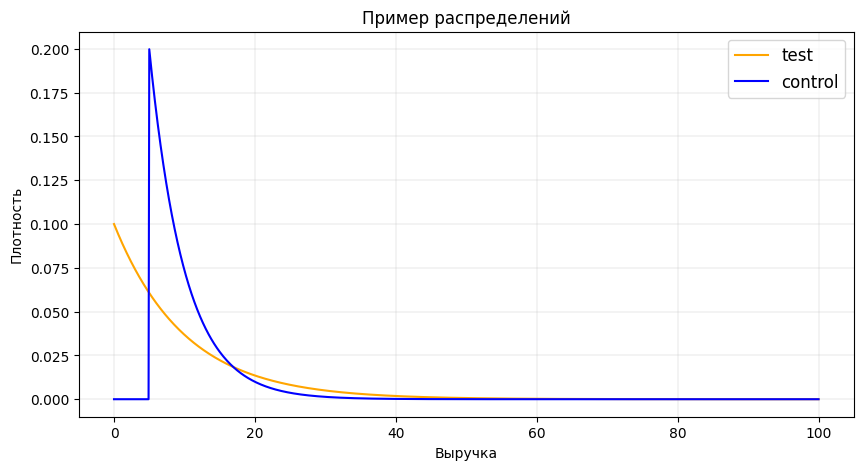

In [ ]:
test_dist = expon(scale=10)
control_dist = expon(loc=5, scale=5)

x= numpy.linspace(0, 100, 1000)

pyplot.figure(figsize=(10, 5))
pyplot.title('Пример распределений', fontsize=12)
pyplot.plot(x, test_dist.pdf(x), label='test', color='orange')
pyplot.plot(x, control_dist.pdf(x), label='control', color='blue')
pyplot.xlabel('Выручка')
pyplot.ylabel('Плотность')
pyplot.legend (fontsize=12)
pyplot.grid(linewidth=0.2)
pyplot.show()

Например, раньше в среднем выручка пользователя была примерно 10 руб и она была не меньше 5 руб (у синей плотности старт выручки в 5 руб), а после введения эффекта часть пользователей стала платить меньше, но средний чек остался таким же 10 руб.

In [ ]:
def check_criterion(test_dist, control_dist, sample_size, N_exps=10000, to_print=True):
  '''
  Функция для проверки t-test критерия для АВ-теста
  Возвращает доверительный интервал для FPR, если флаг to_print = False. Иначе печатает результат.

  Параметры:
    - test dist: Pacnределение тестовой выборки в эксперименте
    - control dist: Pаспределение контрольной выборки в эксперименте
    - sample size: размер выборки теста и контроля
    - N_expѕ: число экспериментов, по которым потом считается FPR
    - to_print: печатать результат или нет. Если нет, то функция возвращает дов, интервал для FPR.
  '''
  numpy.random.seed(35)
  bad_cnt=0
  alpha=0.05

  for i in range(N_exps):
    # Генерирую выборку
    test = test_dist.rvs(sample_size)
    control = control_dist.rvs(sample_size)

    # Запускае критерий и считаю p-value
    pvalue = ttest_ind(test, control, equal_var=False, alternative='two-sided').pvalue

    # Проверие, что pvalue < alpha
    bad_cnt += (pvalue < alpha)

  if to_print:
    print(f"FPR: {round(bad_cnt/N_exps, 4)}")
    print(f"CI={proportion_confint(count=bad_cnt, nobs=N_exps, alpha=0.05, method='wilson')}")
  else:
    return proportion_confint(count=bad_cnt, nobs=N_exps, alpha=0.05, method='wilson')

In [ ]:
check_criterion(test_dist=test_dist, control_dist=control_dist, sample_size=10)

FPR: 0.0689
CI=(0.0640994596515586, 0.07403162374363877)


Таким образом в этом примере мы получили где t-test не работает
- маленькая выборка
- не нормальное распределение обеих выборок

Что ж, мы видим, что t-test не сработал. Истинное α не лежит в доверительном интервале. Но с какого размера выборки t-testна чинает работать правильно?

Как проверить минимальный размер выборки при котором t-test работает?
Давайте просиммулируем эксперимент с разным размером выборки и посмотрим, с какого размера выборки у нас α% лежит в доверительном интервале

In [ ]:
scale = numpy.arange(20, 110, 20)

for N in scale:
  left, right = check_criterion(test_dist=test_dist, control_dist=control_dist, sample_size=10, to_print=False)
  if left < alpha < right:
    print(f"Min dample size: {N}")
    break

In [ ]:
check_criterion(test_dist=test_dist, control_dist=control_dist, sample_size=60)

FPR: 0.0527
CI=(0.0484900114917122, 0.05725351345069507)


#5.2. [Метод Монте Карло (на исторических данных)](https://www.youtube.com/watch?v=gghqd-LrQpM&t=1s)

Или путь 1000 A/A-тестов

Разбить исторические данные на месяцы и категории (или регионы), чтобы получить много выборок и провести на них A/A-тест.

#5.3. [Метод Монте-Карло (определение мощности на исторических данных)](https://www.youtube.com/watch?v=gwgVumVNkCk)

Пусть у нас есть 2 критерия и оба валидны на наших данных. Как понять какой из них лучше использовать на практике?

Правильный ответ - надо сравнить мощность 2 критериев! Но как ее узнать?

Предлагается повторить то жу процедулу, что мы далали выше, только вместо генерации эксперимента, когда верна H0, генерировать эксперимент, когда верна альтернатива. В случае сравнения средних - надо добавить эффект к тесту. И вместо FPRсчитать TPR - сколько раз мы ВЕРНО отвергли нулевую гипотезу (мощность). Чем больше - тем лучше.

Проверим на t-тест.

In [ ]:
import numpy
# from matplotlib import pyplot
# from seaborn import displot
from scipy.stats import norm
# from scipy.stats import expon
from scipy.stats import ttest_ind
# from statsmodels.stats.proportion import proportion_confint
# from statsmodels.stats.weightstats import CompareMeans, DescrStatsW

In [ ]:
numpy.random.seed(42)

rej_cnt = 0
N = 10000
alpha = 0.05

sample_dist = norm(loc=2, scale=3)
mu = sample_dist.expect()

for i in range(N):
  # Генерирую выборку теста и контроля,

  test = sample_dist.rvs(15)
  control = sample_dist.rvs(15) * 2

  # Запускаю критерий и считаю p-valde
  pvalue = ttest_ind(test, control, equal_var=False, alternative='two-sided').pvalue

  # Проверяю, что pvalue < alpha
  rej_cnt += (pvalue < alpha)

print(f"TPR или мощность: {round(rej_cnt / N, 4)}")

TPR или мощность: 0.1938


Видим, что мощность критерия в данном случае равняется 19%. Если есть второй критерий, надо запустить такую проверку для 2-го критерия и оценить какой критерий лучше, на забывая о стат.значимости.

Внесем изменения:
- больший эффект воздействия (выборки отличаются не в 2, а в 3 раза) - больший эффект проще задетектировать
- размер выборки (выборка не 15, а 50) - чем больше выборка, тем проще задетектировать эффект

На практике мощность 80% считается золотым стандартом.